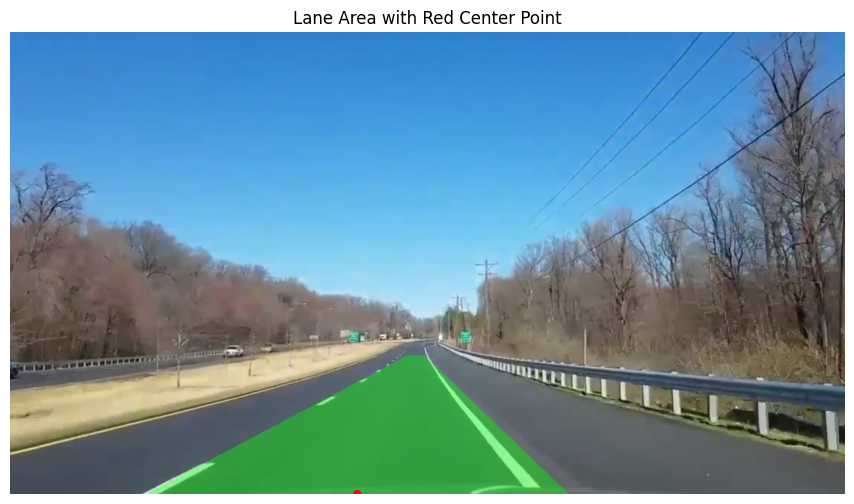

已將結果存成 lane_result.png


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 讀取圖片
img = cv2.imread('road1.png')
scale = 0.5
img = cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)))

# 轉灰階
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 擴張 + 高斯模糊
kernel = np.ones((3,3), np.uint8)
dilated = cv2.dilate(gray, kernel, iterations=1)
blur = cv2.GaussianBlur(dilated, (5,5), 0)

# Canny 邊緣
edges = cv2.Canny(blur, 50, 120)

# ROI 遮罩
height, width = edges.shape
mask = np.zeros_like(edges)
polygon = np.array([[
    (int(0.1*width), height),
    (int(0.35*width), int(0.7*height)),
    (int(0.65*width), int(0.7*height)),
    (int(0.9*width), height)
]], np.int32)
cv2.fillPoly(mask, polygon, 255)
masked_edges = cv2.bitwise_and(edges, mask)
eroded = masked_edges.copy()  # 保留邊緣

# Hough 直線
lines = cv2.HoughLinesP(eroded, 1, np.pi/180, threshold=20, minLineLength=30, maxLineGap=100)

lane_img = img.copy()
left_lines, right_lines = [], []

if lines is not None:
    for x1, y1, x2, y2 in lines[:,0]:
        if x2 == x1: continue
        slope = (y2-y1)/(x2-x1)
        if slope < -0.3: left_lines.append((x1,y1,x2,y2))
        elif slope > 0.3: right_lines.append((x1,y1,x2,y2))

def average_slope_intercept(lines):
    slopes, intercepts = [], []
    for x1,y1,x2,y2 in lines:
        slope = (y2-y1)/(x2-x1)
        intercept = y1 - slope*x1
        slopes.append(slope)
        intercepts.append(intercept)
    if len(slopes)>0:
        return np.mean(slopes), np.mean(intercepts)
    else:
        return None

def make_line_points(y1, y2, slope, intercept):
    if slope is None: return None
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return (x1,int(y1)),(x2,int(y2))

y_bottom = height
y_top = int(0.7*height)

left_fit = average_slope_intercept(left_lines)
right_fit = average_slope_intercept(right_lines)

left_line, right_line = None, None
if left_fit is not None:
    left_line = make_line_points(y_bottom, y_top, *left_fit)
if right_fit is not None:
    right_line = make_line_points(y_bottom, y_top, *right_fit)

# 畫綠色區域（透明）
overlay = lane_img.copy()
if left_line and right_line:
    pts = np.array([[left_line[0], left_line[1], right_line[1], right_line[0]]], np.int32)
    cv2.fillPoly(overlay, pts, (0,255,0))
    alpha = 0.4
    cv2.addWeighted(overlay, alpha, lane_img, 1-alpha, 0, lane_img)

    # 紅點（綠色區底部中間）
    mid_x = (left_line[0][0] + right_line[0][0]) // 2
    mid_y = left_line[0][1]
    cv2.circle(lane_img, (mid_x, mid_y), 6, (0,0,255), -1)
else:
    # fallback：若沒有偵測到線段，畫梯形綠色區域 + 中點
    fallback_pts = np.array([[
        (int(0.35*width), y_bottom),
        (int(0.35*width), int(0.7*height)),
        (int(0.65*width), int(0.7*height)),
        (int(0.65*width), y_bottom)
    ]], np.int32)
    cv2.fillPoly(overlay, fallback_pts, (0,255,0))
    cv2.addWeighted(overlay, 0.4, lane_img, 1-0.4, 0, lane_img)
    cv2.circle(lane_img, ((int(0.35*width)+int(0.65*width))//2, y_bottom), 6, (0,0,255), -1)

# 顯示
plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(lane_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Lane Area with Red Center Point")
plt.show()

# 存圖片
cv2.imwrite("lane_result.png", lane_img)
print("已將結果存成 lane_result.png")
